In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan
from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI
from bmadx.bmad_torch.track_torch import particle_to_beam

from analysis import *

plt.rcParams["figure.dpi"] = 300

In [2]:
# load bmadx Particle
import pickle
with open('OPAL/dogleg_beam_1e5_3mm_p1mrad_p1mrad.pkl', 'rb') as f:
    bmadx_par = pickle.load(f)
bmadx_par

Particle(x=array([-0.00099348,  0.00027404, -0.00367478, ..., -0.00959441,
       -0.00340727, -0.00110286]), px=array([ 7.97345022e-05,  3.00696572e-04,  1.50594777e-04, ...,
       -1.19931861e-04, -1.53825657e-04,  1.64514088e-04]), y=array([3.06848890e-04, 1.43730977e-03, 3.38045347e-04, ...,
       1.83633222e-03, 1.03825473e-03, 7.06008173e-05]), py=array([-4.12952086e-05, -4.28425526e-04, -1.01103722e-04, ...,
       -3.64960827e-04, -1.72518162e-04, -1.30225064e-04]), z=array([-2.36835321e-03, -7.05018929e-04, -8.57450708e-05, ...,
        1.46516262e-03,  1.32642161e-03,  1.40659919e-03]), pz=array([ 0.00017077, -0.00120938, -0.00044498, ...,  0.00018299,
        0.00021113,  0.00026717]), s=0.0, p0c=43400000.0, mc2=510998.94999999995)

In [3]:
# create bmadx torch beam
gt_beam = particle_to_beam(bmadx_par)
torch.save(gt_beam, 'gt_beam.pt')

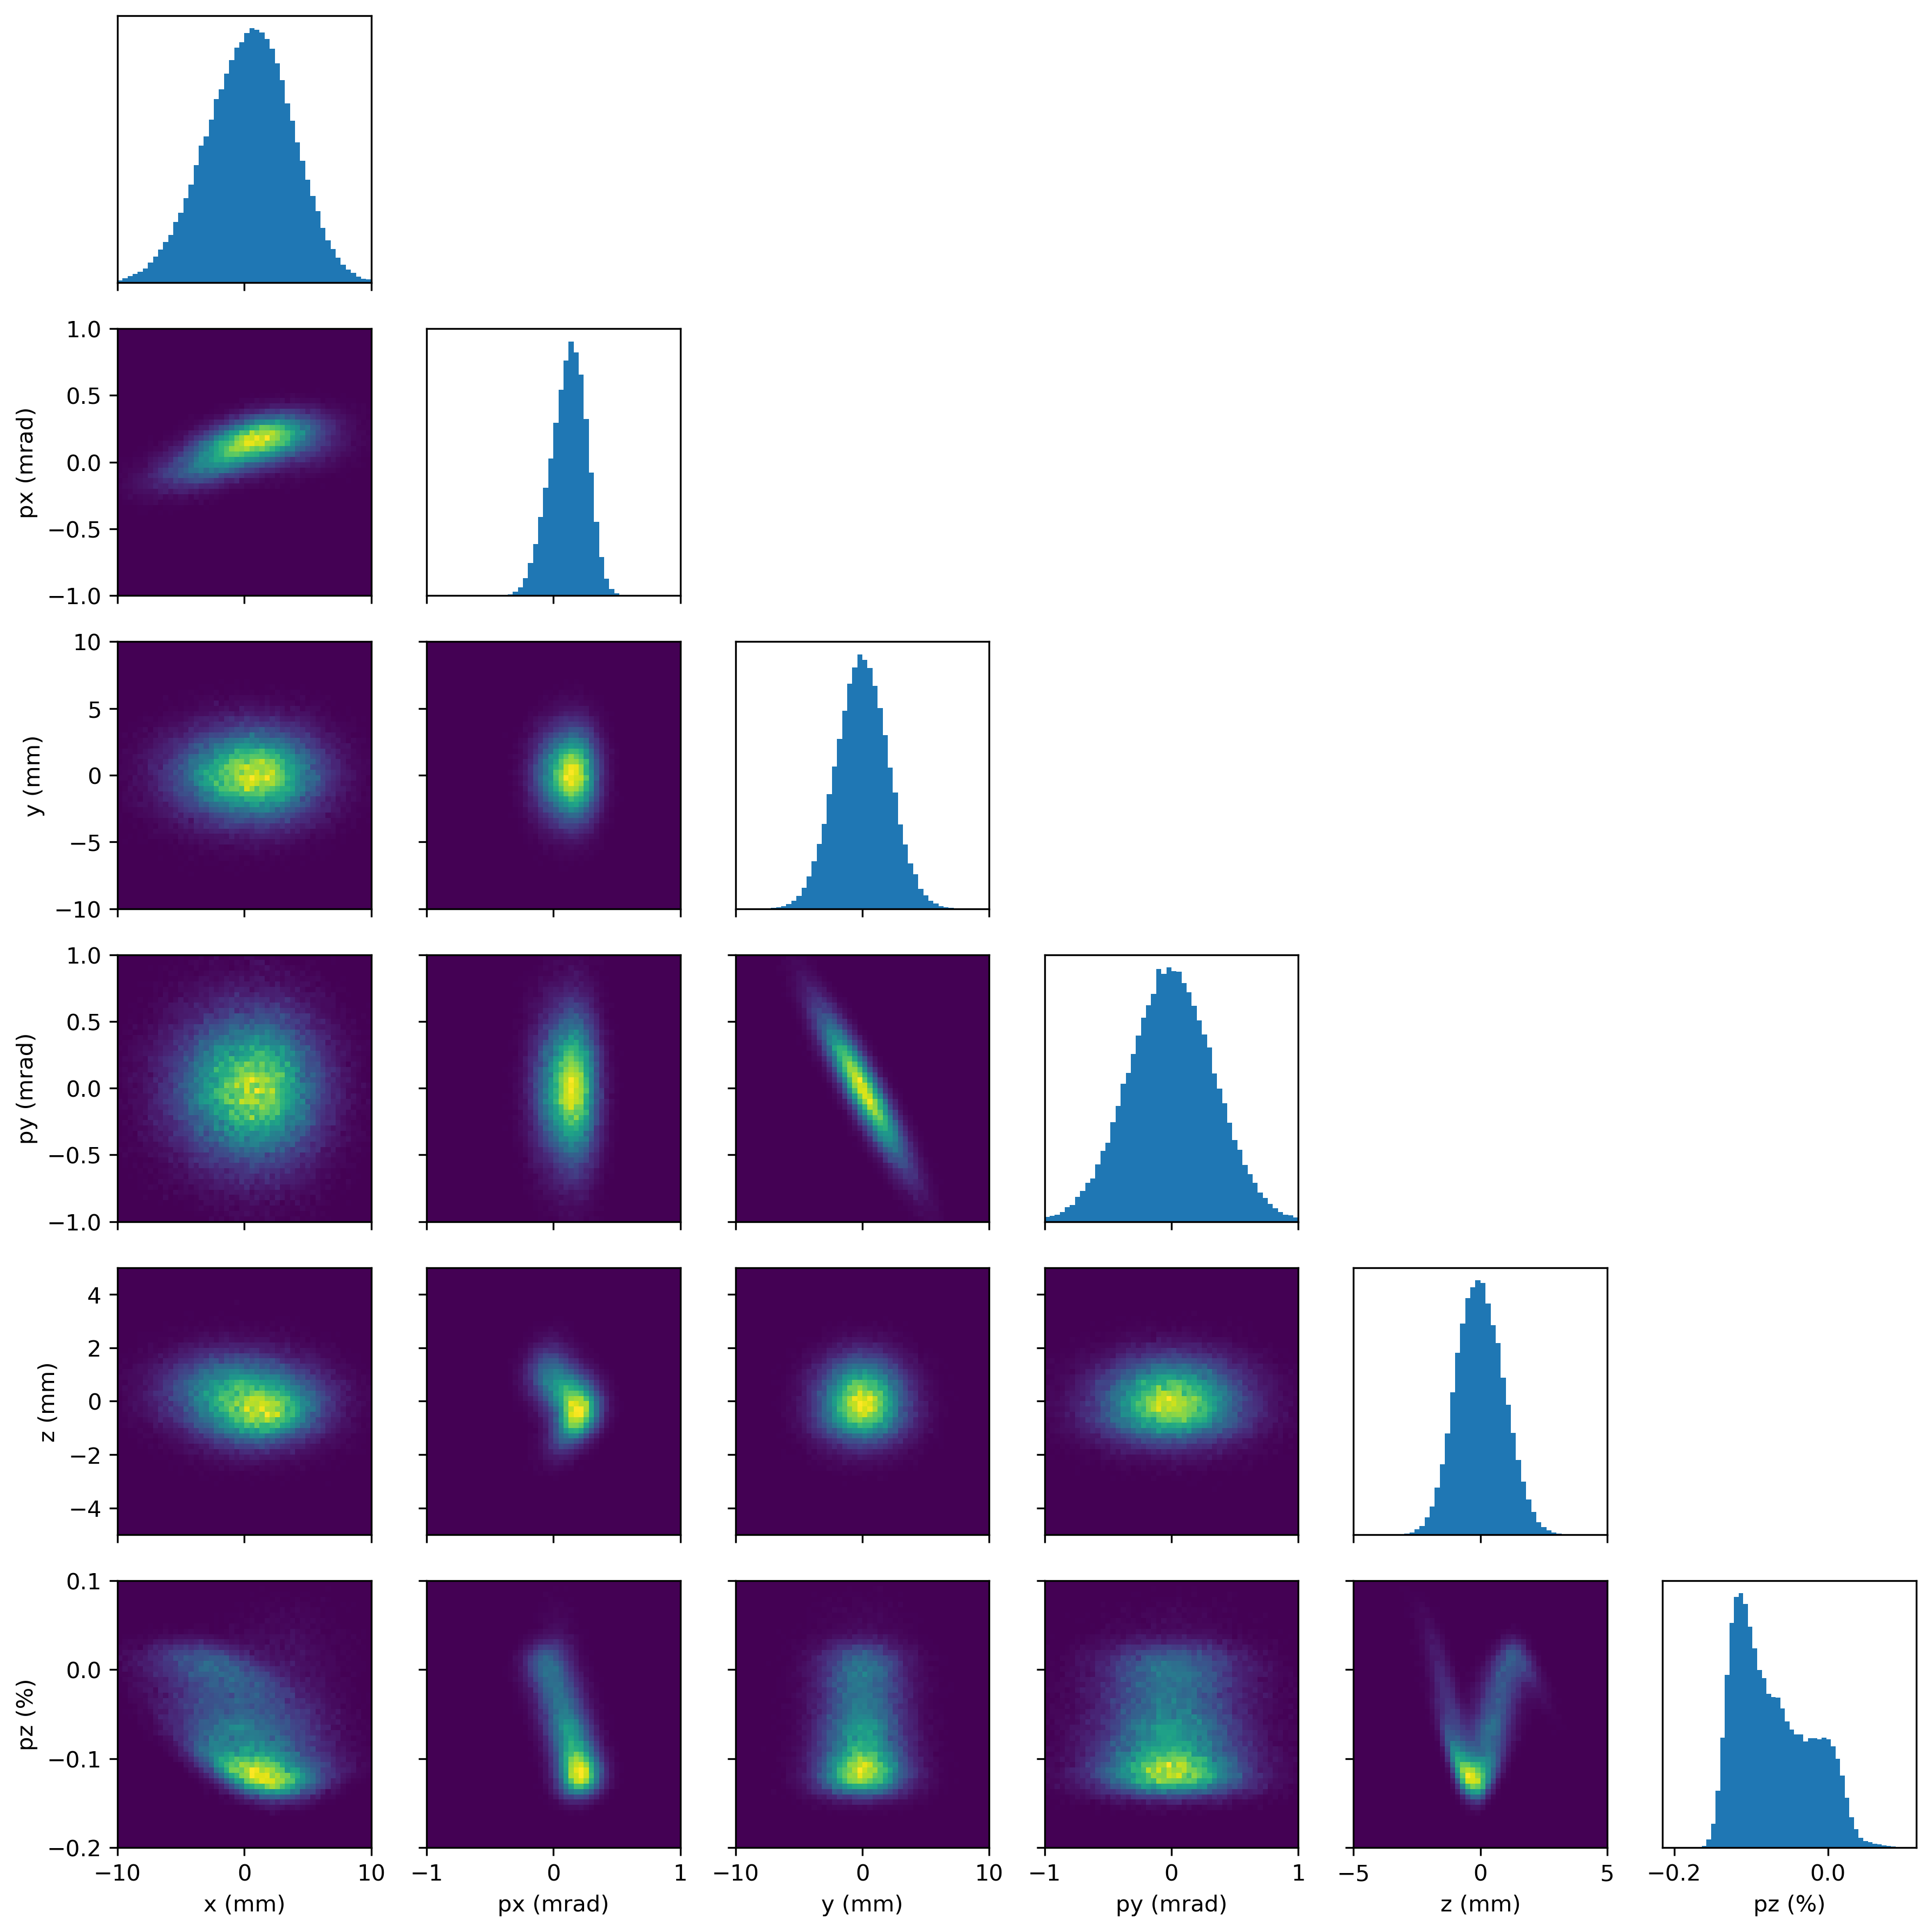

In [4]:
#plot gt beam
lims = np.array([[-10e-3, 10e-3],
                 [-1e-3, 1e-3],
                 [-10e-3, 10e-3],
                 [-1e-3, 1e-3],
                 [-5e-3, 5e-3],
                 [-2e-3, 1e-3]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

In [5]:
# triplet params obtained from triplet-opt.ipynb
k1=    0.778835
k2 =  -12.727689
k3  =  14.003951


In [6]:
# diagnostic beamline:
p0c = 43.4e6
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-5, 5, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-15, 15, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


In [7]:
# generate and save train and test datasets
save_dir = '3d_scan'
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, '3d_scan_train.dset')
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as '3d_scan/3d_scan_train.dset'
torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


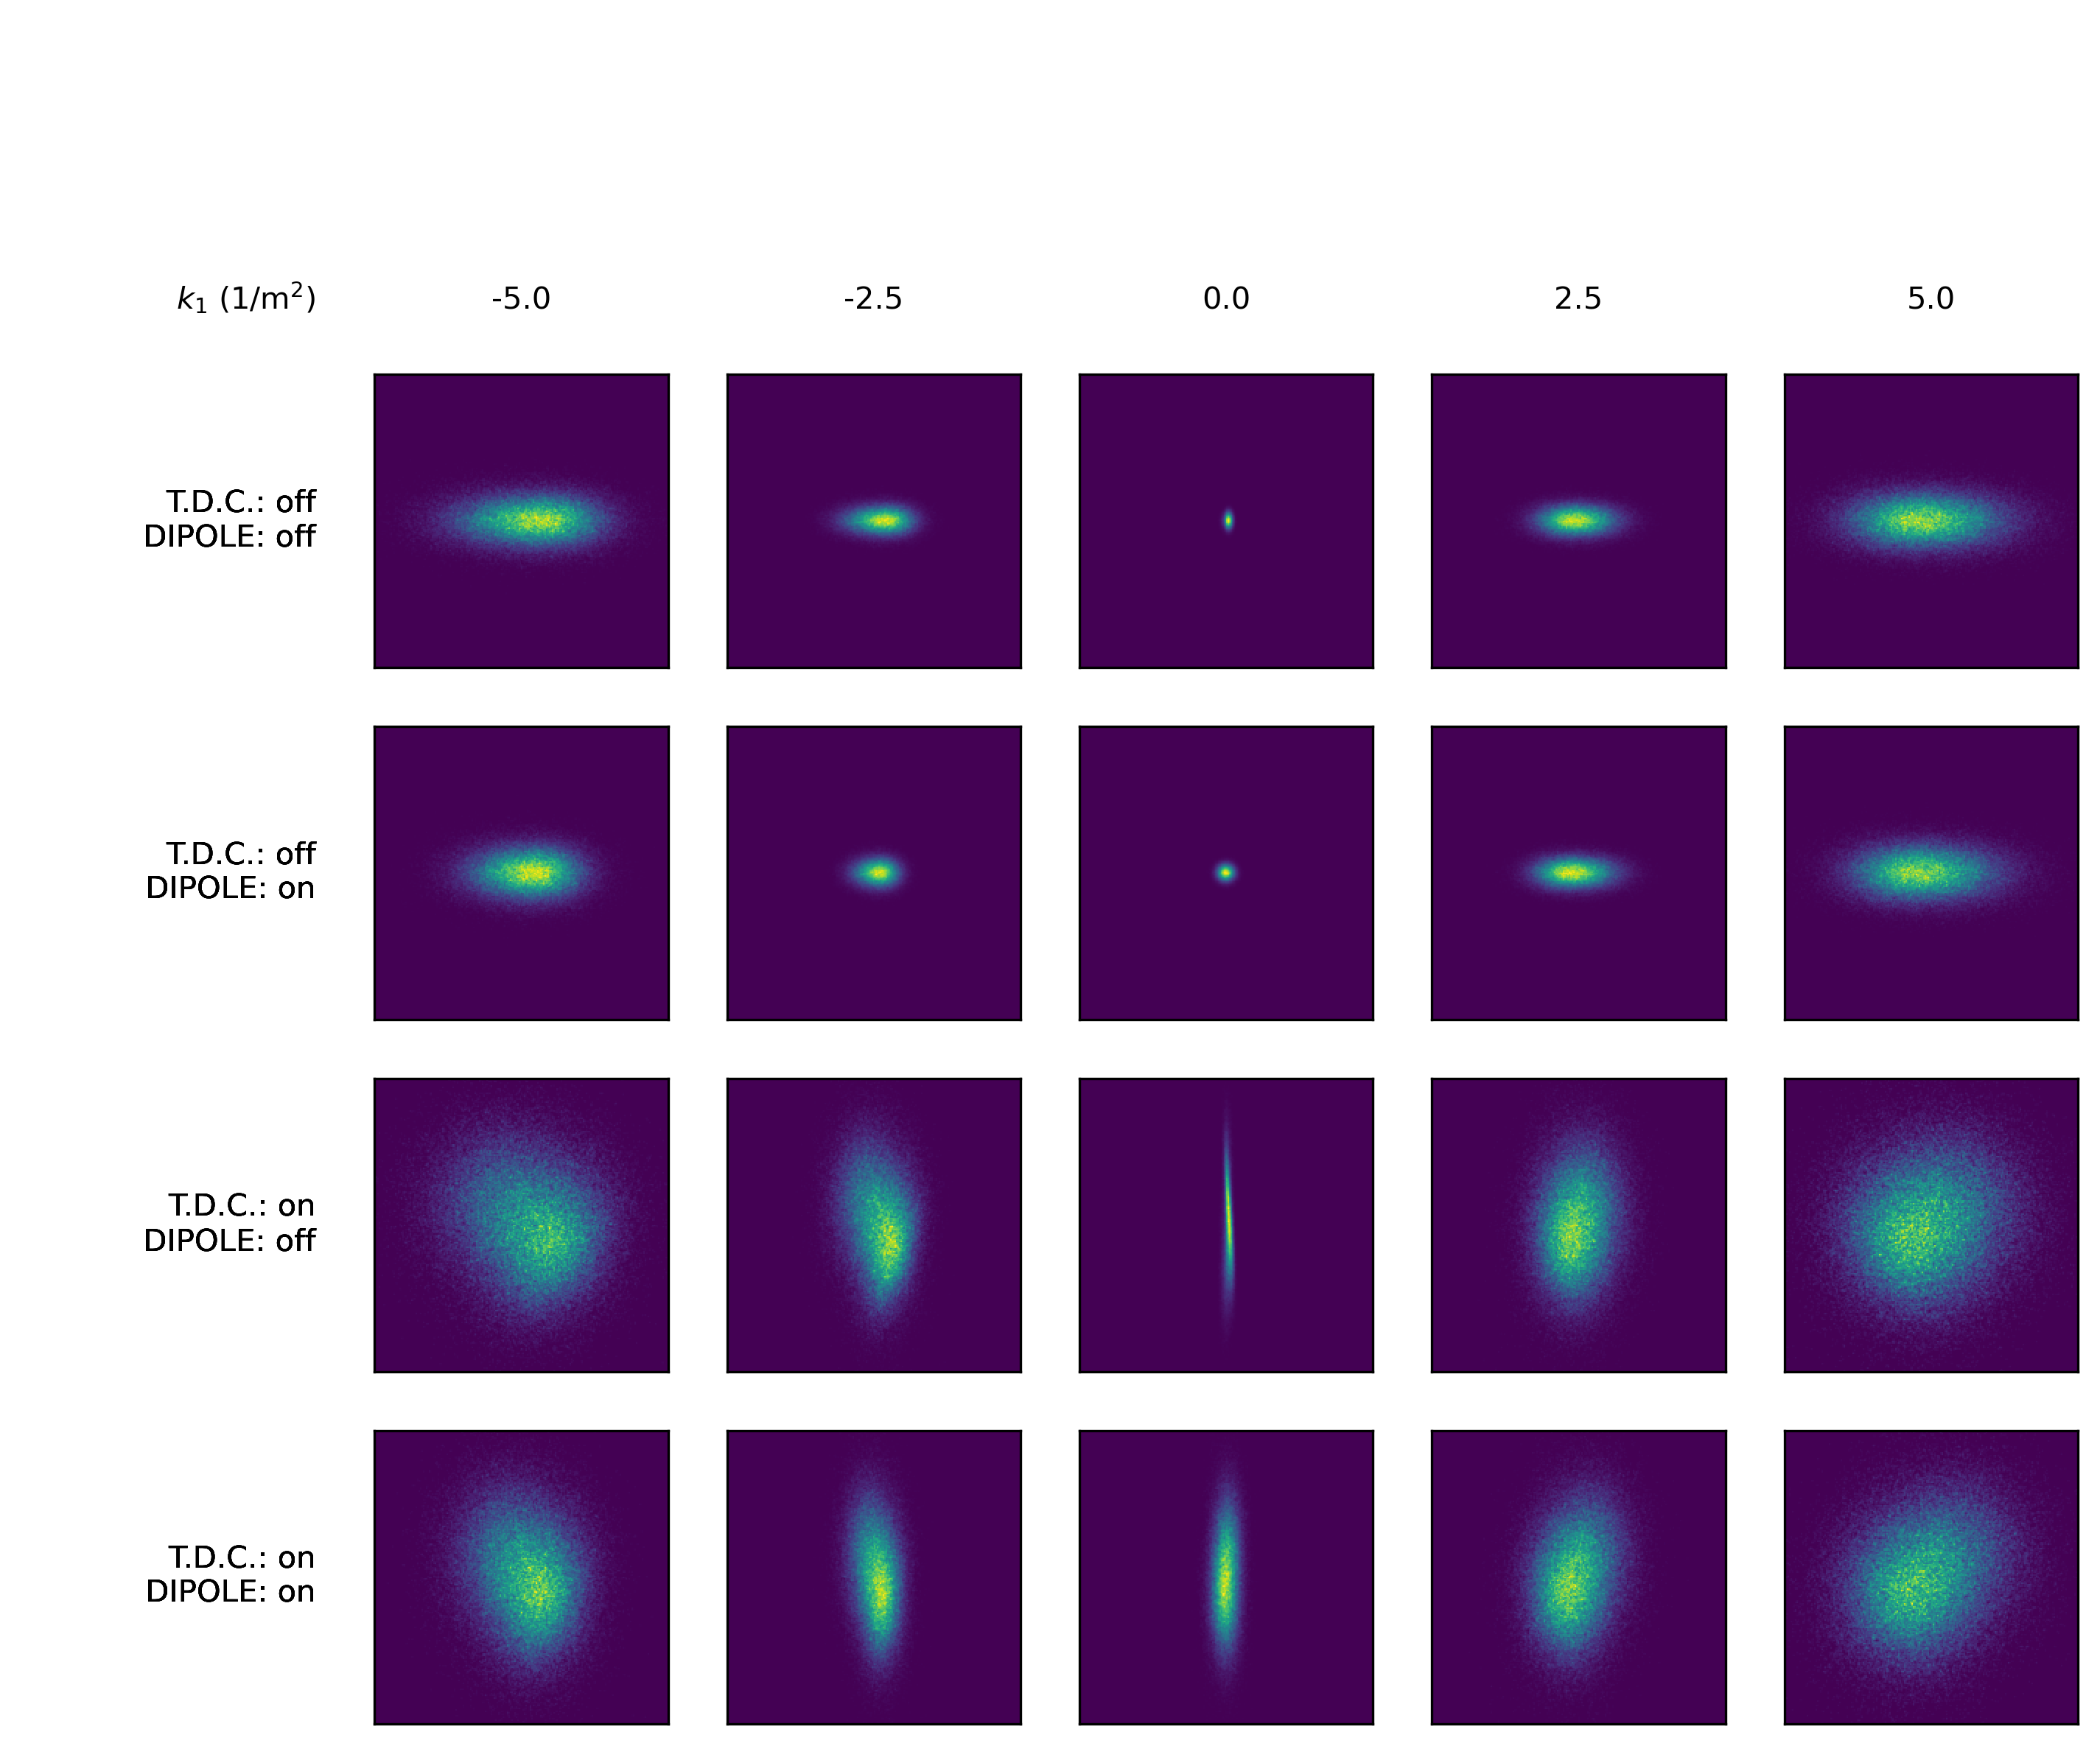

In [8]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
plt.show()

In [9]:
%%time

# training 
pred_beam = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 100_000, 
    device = 'cuda',
    lr=1e-3
    )

Using device: cuda


/home/jp/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4.6071e-05, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(5.4266e-06, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(4.4631e-06, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(4.7501e-06, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(4.8235e-06, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(6.2308e-06, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(4.6407e-06, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(4.6535e-06, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(4.4226e-06, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(4.8671e-06, device='cuda:0', grad_fn=<MulBackward0>)
CPU times: user 3min 46s, sys: 1min 24s, total: 5min 10s
Wall time: 5min 10s


In [10]:
pred_par = pred_beam.numpy_particles()

In [11]:
from scipy.ndimage import gaussian_filter

def get_beam_fraction_hist2d(hist2d, fraction: float):
    levels = np.linspace(hist2d.max(), 0.0, 100)
    total = hist2d.sum()
    final_beam = np.copy(hist2d)
    for level in levels:
        test_beam = np.where(hist2d>=level, hist2d, 0.0)
        test_frac = test_beam.sum() / total
        if test_frac > fraction:
            final_beam = test_beam
            break

    return final_beam

def plot_projections_with_contours(
        reconstruction,
        ground_truth = None,
        contour_percentiles = [50, 95],
        contour_smoothing_r = 1,
        contour_smoothing_gt = 1,
        coords = ('x', 'px', 'y', 'py', 'z', 'pz'),
        bins = 200,
        scale = 1e3,
        background = 0,
        same_lims = False,
        custom_lims = None,
        figsize=(12, 12)
        ):
    
    SPACE_COORDS = ('x', 'y', 'z')
    MOMENTUM_COORDS = ('px', 'py', 'pz')

    n_coords = len(coords)
    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)
    #fig_size = (n_coords*2,) * 2

    fig, ax = plt.subplots(n_coords, n_coords, figsize=figsize, dpi=300)
    mycmap = plt.get_cmap('viridis')
    mycmap.set_under(color='white') # map 0 to this color

    all_coords = []
    
    for coord in coords:
        all_coords.append(getattr(reconstruction, coord))
    
    all_coords = np.array(all_coords)
    
    if same_lims:
        if custom_lims is None:
            coord_min = np.ones(n_coords)*all_coords.min()
            coord_max = np.ones(n_coords)*all_coords.max()
        elif len(custom_lims) == 2:
            coord_min = np.ones(n_coords)*custom_lims[0]
            coord_max = np.ones(n_coords)*custom_lims[1]
        else:
            raise ValueError("custom lims should have shape 2 when same_lims=True")
    else:
        if custom_lims is None:
            coord_min = all_coords.min(axis=1)
            coord_max = all_coords.max(axis=1)
        elif custom_lims.shape == (n_coords, 2):
            coord_min = custom_lims[:,0]
            coord_max = custom_lims[:,1]
        else:
            raise ValueError("custom lims should have shape (n_coords x 2) when same_lims=False")

    for i in range(n_coords):
        x_coord = coords[i]

        if x_coord in SPACE_COORDS and scale==1e3:
            x_coord_unit = 'mm'
        elif x_coord in SPACE_COORDS and scale==1:
            x_coord_unit = 'm'
        elif x_coord in MOMENTUM_COORDS and scale==1e3:
            x_coord_unit = 'mrad'
        elif x_coord in MOMENTUM_COORDS and scale==1:
            x_coord_unit = 'rad'
        else:
            raise ValueError("""scales should be 1 or 1e3,
            coords should be a subset of ('x', 'px', 'y', 'py', 'z', 'pz')
            """)

        x_array = getattr(reconstruction, x_coord)*scale
        ax[n_coords-1,i].set_xlabel(f'{x_coord} ({x_coord_unit})')
        min_x = coord_min[i]*scale
        max_x = coord_max[i]*scale

        if i>0:
            ax[i,0].set_ylabel(f'{x_coord} ({x_coord_unit})')

        ax[i,i].hist(
            x_array,
            bins=bins,
            range=([min_x, max_x]),
            density=True,
            histtype = 'step'
        )
        if ground_truth is not None:
            ax[i,i].hist(
                getattr(ground_truth, x_coord)*scale,
                bins = bins,
                range = ([min_x, max_x]),
                density = True,
                histtype = 'step'
            )
        
        ax[i,i].yaxis.set_tick_params(left=False, labelleft=False)

        if i!= n_coords-1:
            ax[i,i].xaxis.set_tick_params(labelbottom=False)

        for j in range(i+1, n_coords):
            y_coord = coords[j]
            y_array = getattr(reconstruction, y_coord)*scale
            min_y = coord_min[j]*scale
            max_y = coord_max[j]*scale
            rng=[[min_x, max_x],[min_y, max_y]]
            
            hist, x_edges, y_edges, _ = ax[j,i].hist2d(
                x_array,
                y_array,
                bins = bins,
                range = rng,
                cmap = mycmap,
                vmin = background
            )
            
            x_centers = (x_edges[:-1] + x_edges[1:]) / 2
            y_centers = (y_edges[:-1] + y_edges[1:]) / 2

            for k, percentile in enumerate(contour_percentiles):
                h_r_fractions = get_beam_fraction_hist2d(hist, percentile/100)
                ax[j,i].contour(
                    x_centers, 
                    y_centers, 
                    gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                    #h_r_fractions.T,
                    levels=[1],
                    linestyles="--",
                    colors=COLORS[k],
                    linewidths=1
                )

                if ground_truth is not None:
                    h_gt, _, _ = np.histogram2d(
                        getattr(ground_truth, x_coord)*scale,
                        getattr(ground_truth, y_coord)*scale,
                        bins = bins,
                        range = rng
                    )
                    h_gt_fractions = get_beam_fraction_hist2d(h_gt, percentile/100)

                    ax[j,i].contour(
                        x_centers, 
                        y_centers, 
                        gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                        #h_gt_fractions.T,
                        levels=[1],
                        linestyles="-",
                        colors=COLORS[k],
                        linewidths=1
                    )  

            ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])
            ax[i,j].set_visible(False)

            if i != 0:
                ax[j, i].yaxis.set_tick_params(labelleft=False)
            
            if j != n_coords-1:
                ax[j,i].xaxis.set_tick_params(labelbottom=False)

    fig.tight_layout()

    return fig, ax

/tmp/ipykernel_1196653/709503537.py:167: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])


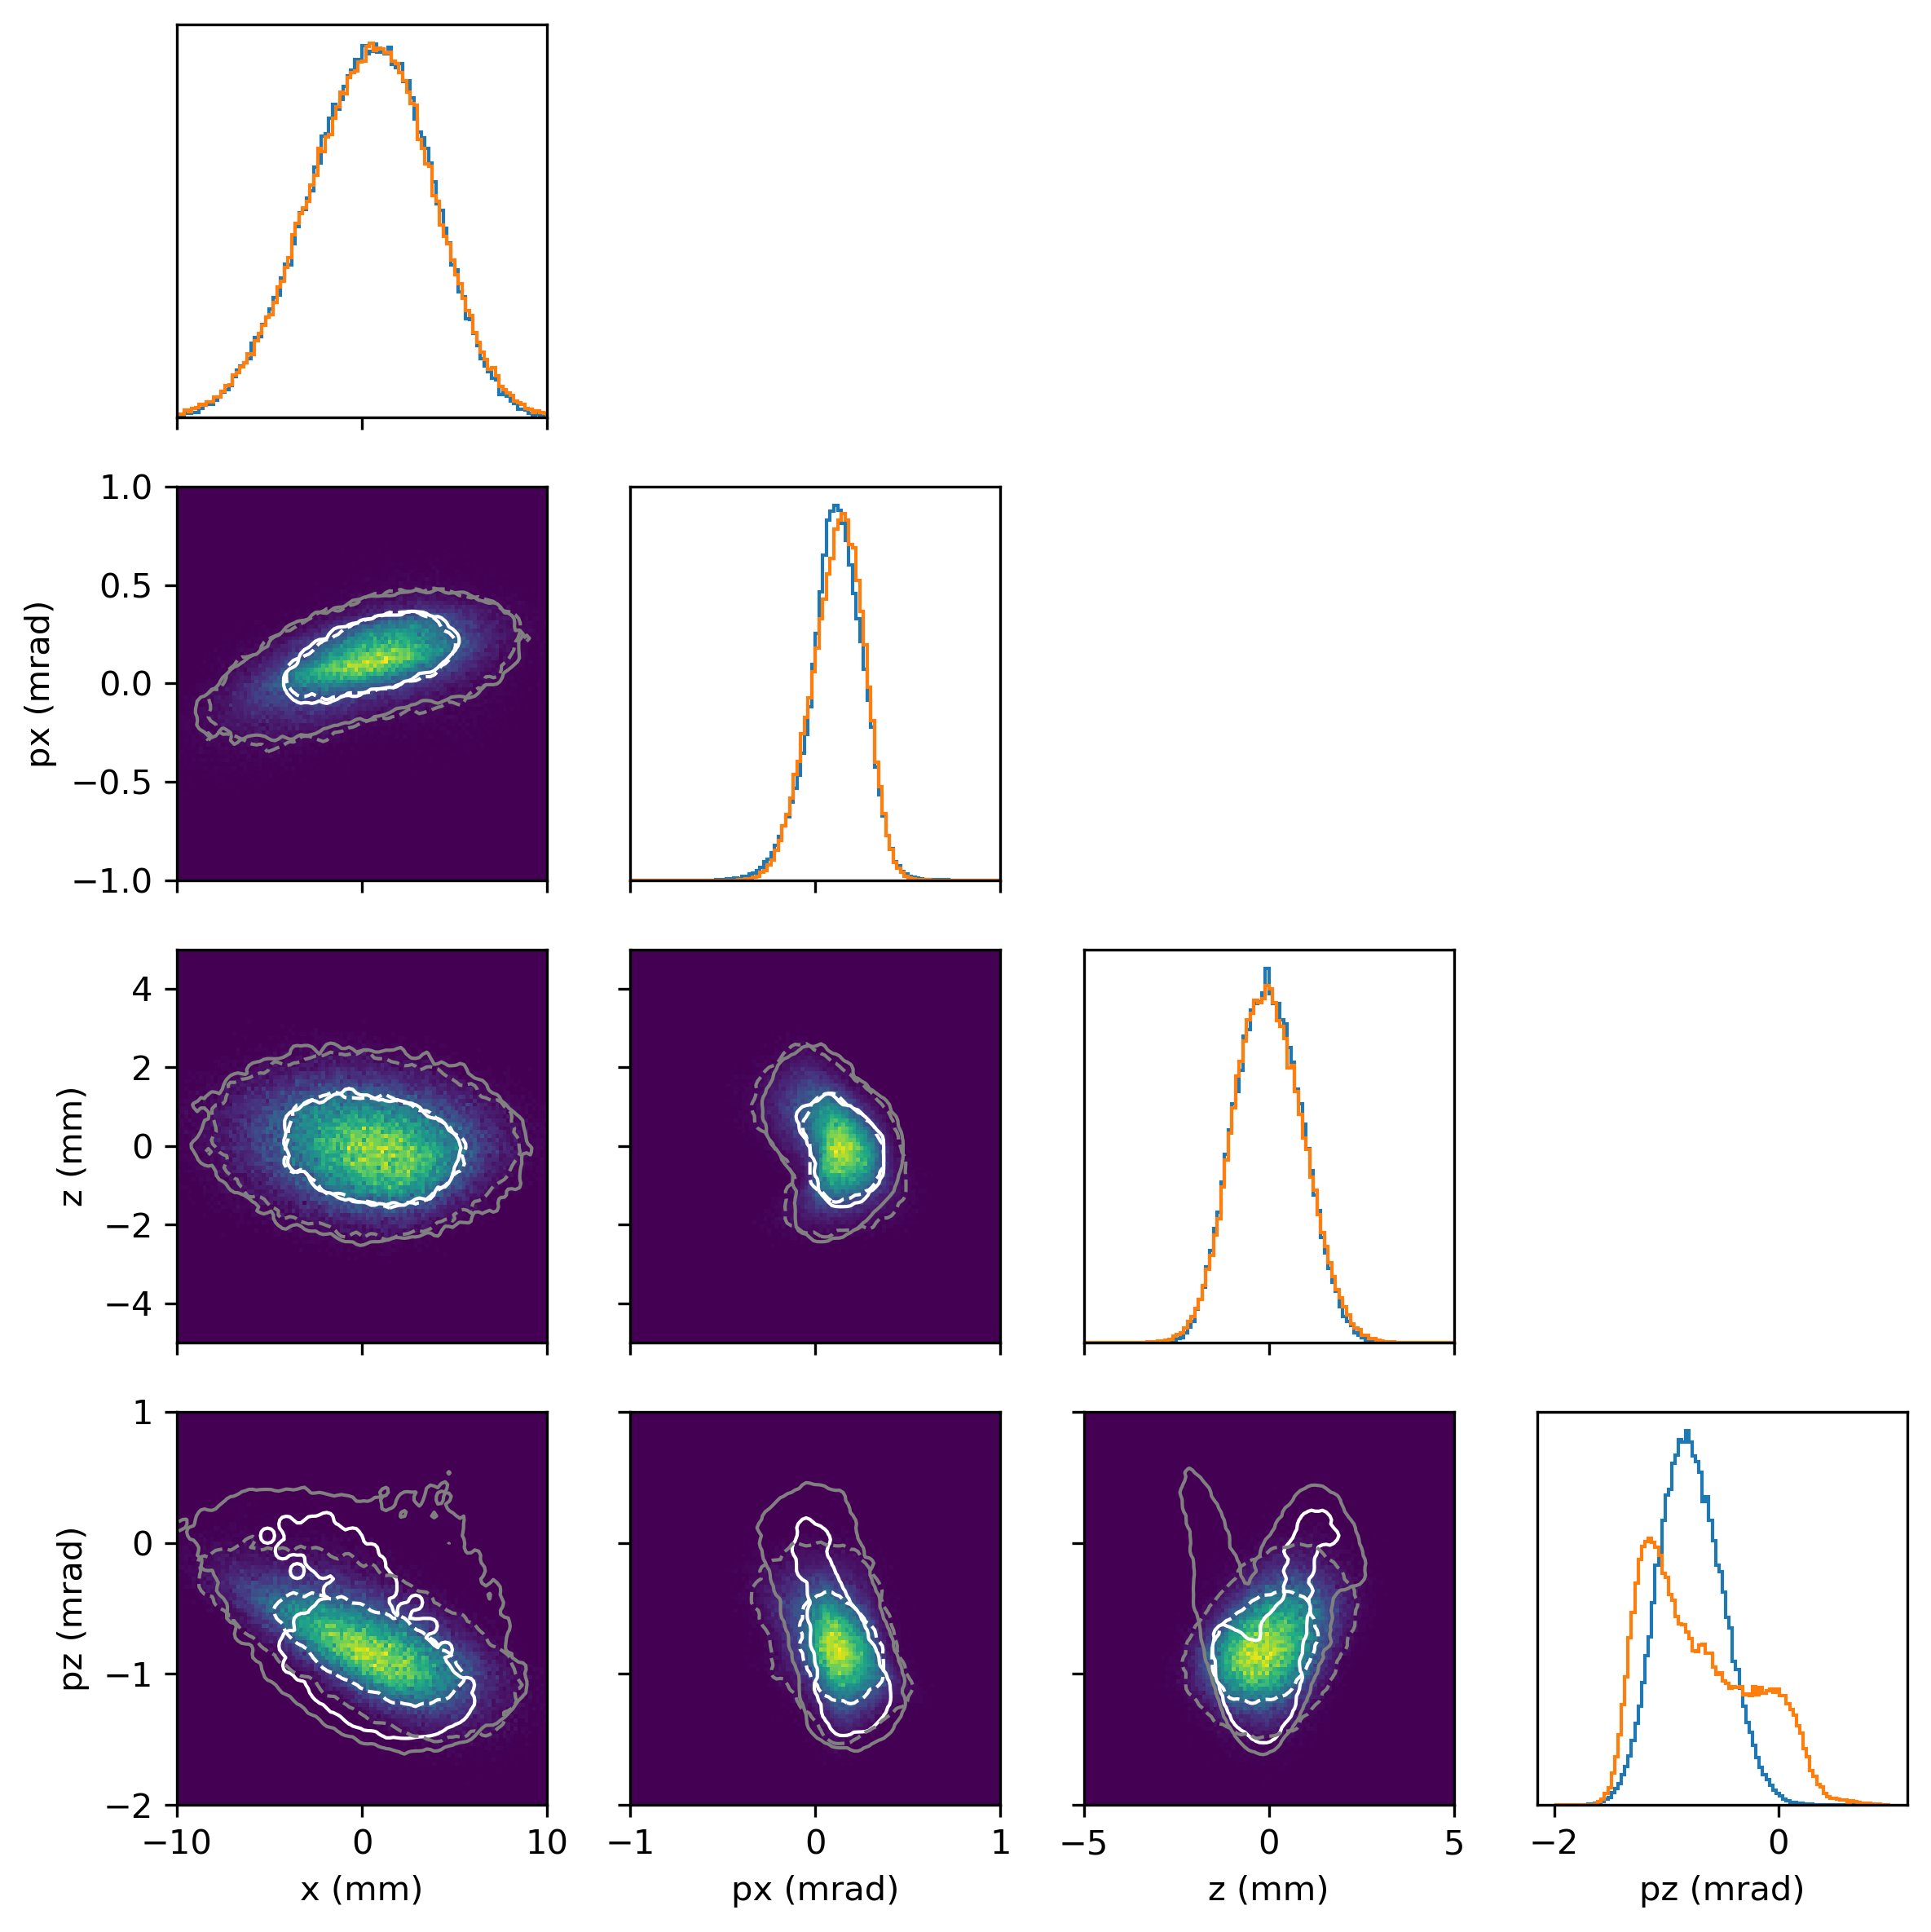

In [12]:
lims = np.array([[-10e-3, 10e-3],
                 [-1e-3, 1e-3],
                 [-5e-3, 5e-3],
                 [-2e-3, 1e-3]]) 
fig, ax = plot_projections_with_contours(
    pred_par,
    ground_truth = gt_beam.numpy_particles(),
    coords=['x', 'px', 'z', 'pz'],
    custom_lims = lims,
    bins = 100,
    figsize=(8,8)
)
plt.show()

In [13]:
# plots lims
z_lims = (-4, 4)
pz_lims = (-0.17, 0.10)
x_lims = (-15, 15)
px_lims= (-0.4, 0.5)
# slicing params
n_slices = 11
#z_min = pred_par.z.mean() - 2*pred_par.z.std()
#z_max = pred_par.z.mean() + 2*pred_par.z.std()
z_min = -0.00185044
z_max = 0.00185044
z_slices = np.linspace(z_min, z_max, n_slices+1)

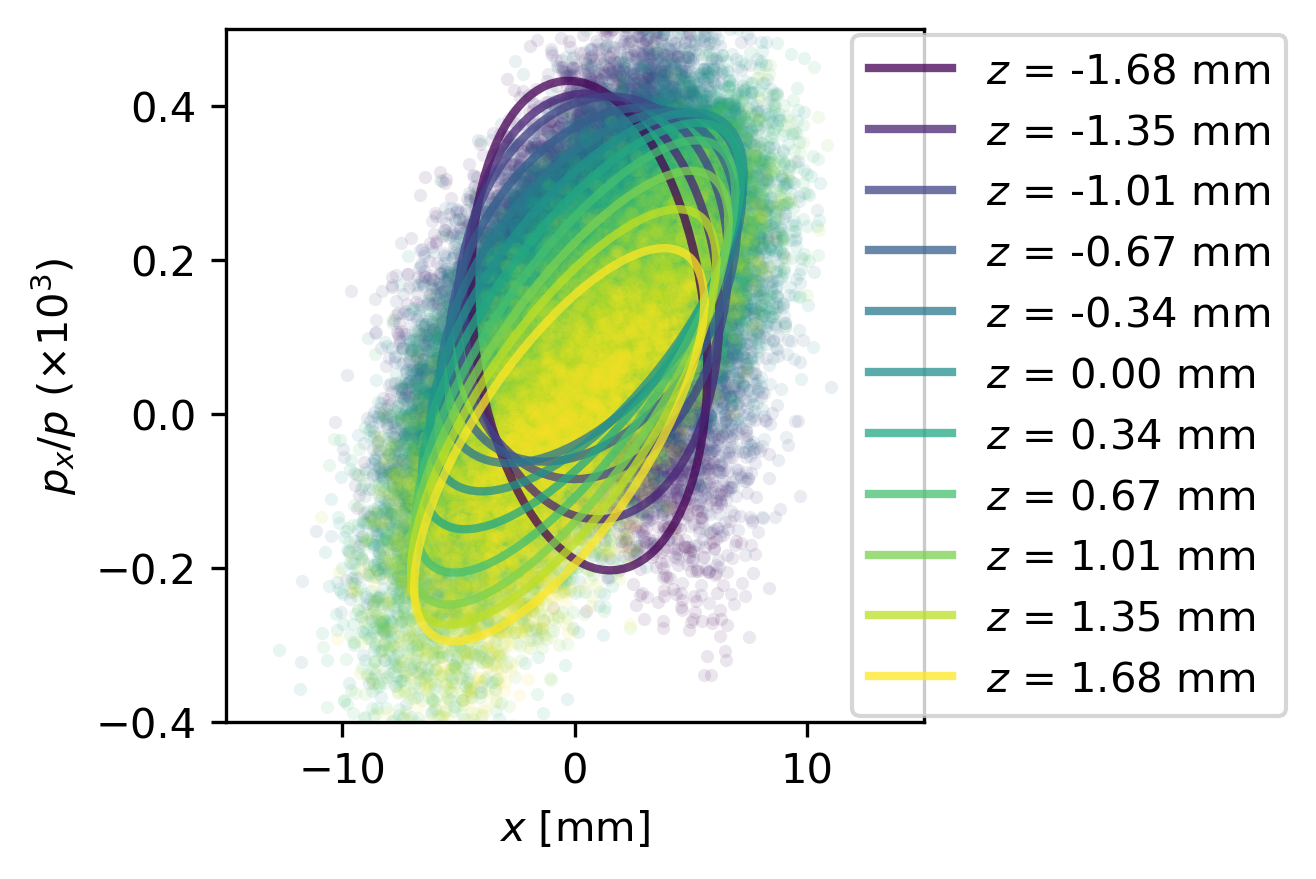

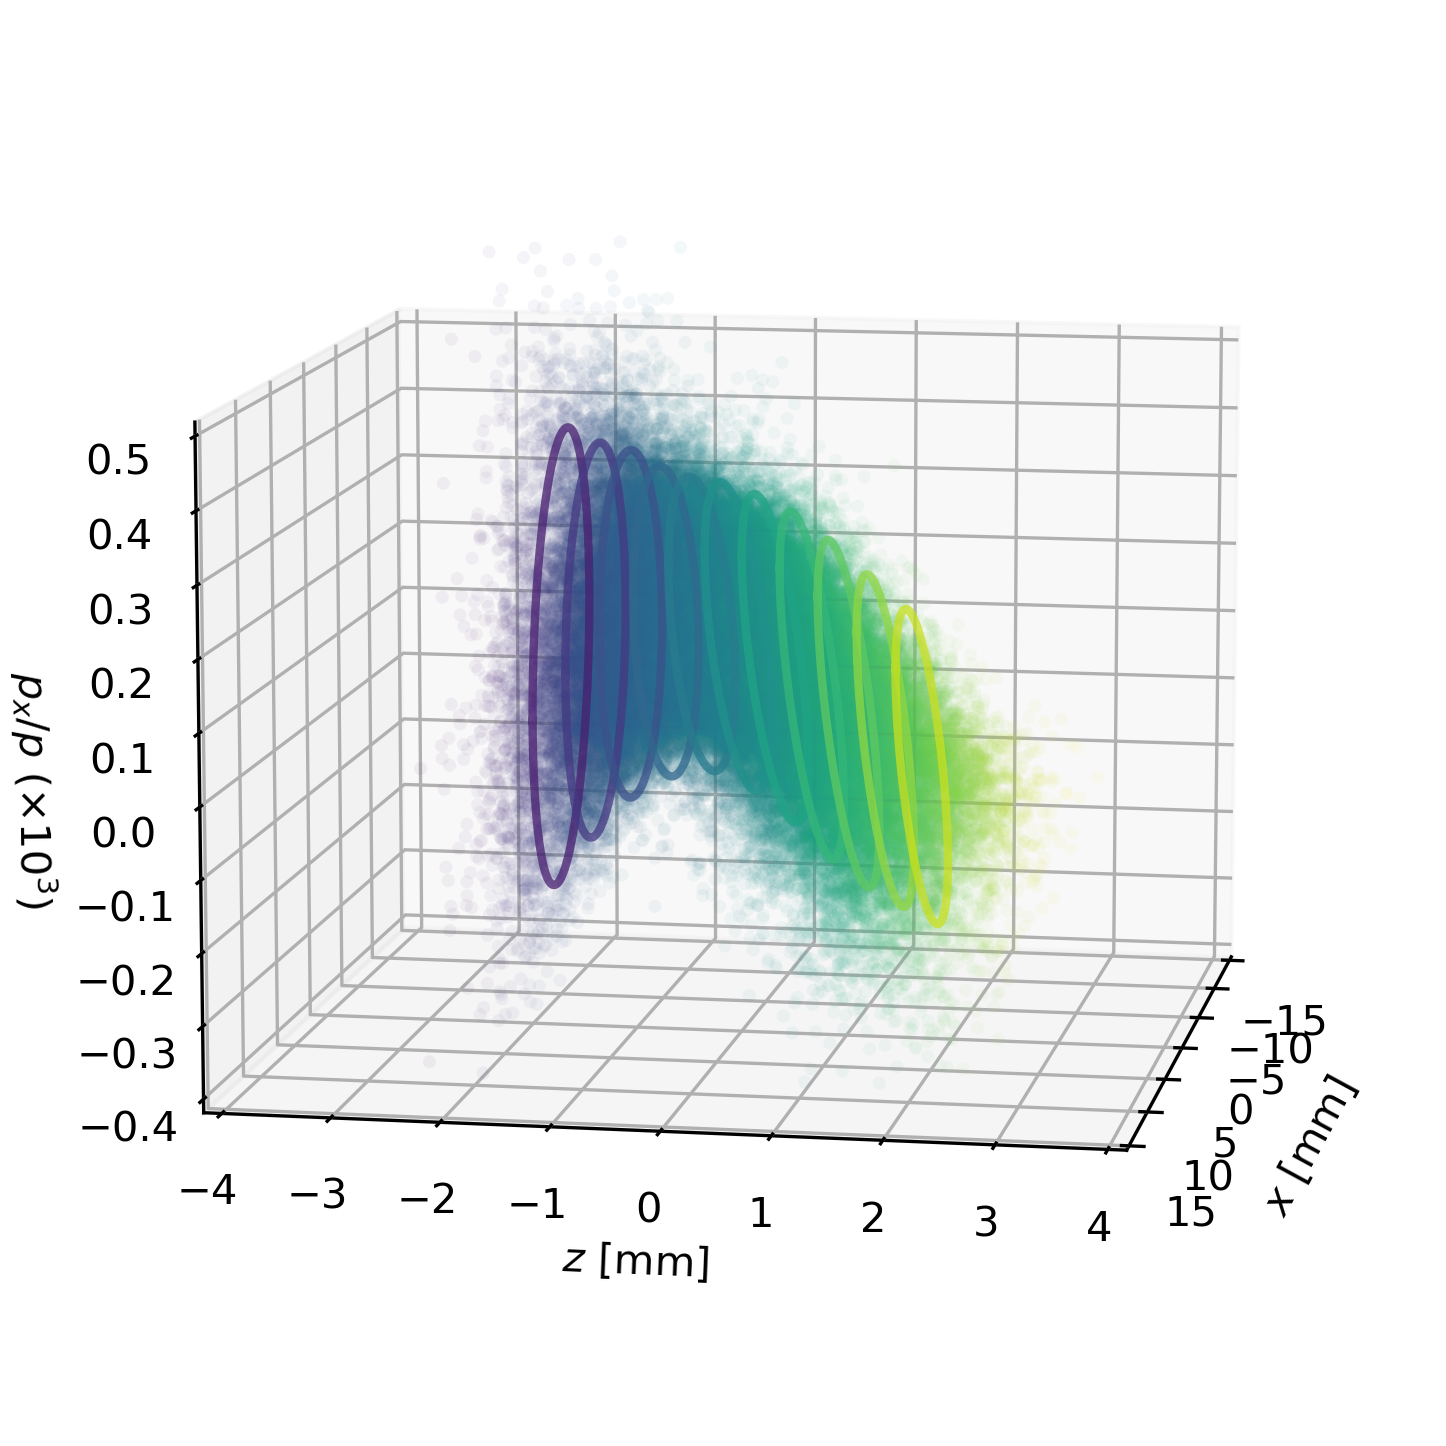

In [14]:
fig, ax = plot_sliced_ps_2d(pred_par, z_slices,  'z', x_lim=x_lims, px_lim=px_lims)
plt.show()
fig, ax = plot_sliced_ps_3d(pred_par, z_slices,  'z', x_lim=x_lims, px_lim=px_lims, z_lim=z_lims)
plt.show()

In [15]:
gamma = np.sqrt( 1 + (p0c / 0.511e6)**2)
gamma

84.93739374206895

In [16]:
emittance(pred_par, gamma)

(3.327045220908537e-05, 2.4485464411738744e-05, 2.0187837274926042e-05)